In [1]:
# List the available reducers
from slc.data import list_reducers

reducers = list_reducers()

print("ImageCollection Reductions:", reducers)

ImageCollection Reductions: ['And', 'Or', 'allNonZero', 'anyNonZero', 'bitwiseAnd', 'bitwiseOr', 'circularMean', 'circularStddev', 'circularVariance', 'count', 'countDistinct', 'countDistinctNonNull', 'countRuns', 'first', 'firstNonNull', 'kendallsCorrelation', 'kurtosis', 'last', 'lastNonNull', 'max', 'mean', 'median', 'min', 'minMax', 'mode', 'product', 'sampleStdDev', 'sampleVariance', 'skew', 'stdDev', 'sum', 'variance']


In [2]:
reducers = [
    "max",
    "mean",
    "median",
    "min",
    "sampleStdDev",
    "skew",
]

In [3]:
# List the bands determined by the previous experiment
from slc.models import bands_from_importance

sentinel_bands, indices = bands_from_importance(
    "../reports/band_importance.csv", top_n=10
)

print("Level-2A bands:", sentinel_bands)
print("Indices:", indices)

Level-2A bands: ['B11']
Indices: ['BRBA', 'GDVI', 'IKAW', 'MBWI', 'MIRBI', 'MLSWI26', 'MLSWI27', 'SWI', 'WI2015']


In [4]:
# Perform a grid exploration over all reducers and number of composites
from datetime import datetime
from itertools import product
from pathlib import Path
from time import sleep
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
from sklearn.base import ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_validate
from tqdm.notebook import tqdm

from slc.data import sentinel_composite
from slc.features import interpolate_data, load_dataset, to_float32

tz = ZoneInfo("CET")

model = RandomForestClassifier(n_jobs=-1, random_state=42)
search_space = {
    "num_composites": [12, 6, 4, 2, 1],  # Reverse to start with slowest
    "temporal_reducers": [[reducer] for reducer in reducers],
    "indices": [indices],
    "sentinel_bands": [sentinel_bands],
}
scoring = {"F1 Score": make_scorer(f1_score)}
target_folder = Path("../data/processed/target/")


def _create_dataset(
    target_folder: Path, search_point: dict
) -> tuple[pd.DataFrame, pd.Series]:
    # Create data_path and ensure directory exists
    reducer = search_point["temporal_reducers"][0]
    composites = search_point["num_composites"]
    data_folder = Path(f"../data/processed/compositing/data_{reducer}_{composites}/")
    data_folder.mkdir(parents=True, exist_ok=True)

    # Create the 2A composite if it does not exist
    data_folder.mkdir(parents=True, exist_ok=True)
    for target_path in tqdm(list(target_folder.glob("*.tif"))):
        data_path = data_folder / target_path.name
        year = int(target_path.stem.split("_")[-1])

        # Create the composite (retrying if it fails)
        batch_size = None
        init_bs = 512
        while not data_path.exists():
            try:
                sentinel_composite(
                    target_path_from=target_path,
                    data_path_to=data_path,
                    time_window=(
                        datetime(year, 1, 1, tzinfo=tz),
                        datetime(year + 1, 1, 1, tzinfo=tz),
                    ),
                    batch_size=batch_size,
                    **search_point,
                )
            except KeyboardInterrupt as exc:  # noqa: PERF203
                raise KeyboardInterrupt from exc
            except Exception:  # noqa: BLE001
                if batch_size is not None:
                    if batch_size < init_bs / 2:
                        sleep_time = 100 * 256 / batch_size
                        print(f"Sleeping for {sleep_time} seconds")
                        sleep(sleep_time)

                    batch_size = batch_size // 2
                else:
                    batch_size = init_bs

                print(f"Retrying with batch_size={batch_size}")

    # Fill missing values by linear (circular) interpolation
    data, target = load_dataset(data_folder, target_folder)
    interpolated_data = interpolate_data(data)
    interpolated_data = to_float32(interpolated_data)

    return interpolated_data, target


def _check_row_exists(search_point: dict) -> bool:
    try:
        history = pd.read_csv("../reports/compositing.csv")
        for _, row in history.iterrows():
            if list(row[:2]) == [
                search_point["temporal_reducers"][0],
                search_point["num_composites"],
            ]:
                return True
    except FileNotFoundError:
        return False
    else:
        return False


def _callback(scores: dict, scoring: dict, search_point: dict) -> None:
    # Read the compositing.csv
    compositing = "../reports/compositing.csv"
    try:
        history = pd.read_csv(compositing)
    except FileNotFoundError:
        columns = ["Reducer", "Composites", *list(scoring.keys())]
        history = pd.DataFrame(columns=columns)

    # Store the scores in the dataframe
    first_columns = [
        search_point["temporal_reducers"][0],
        search_point["num_composites"],
    ]
    last_columns = [scores[f"test_{key}"].mean() for key in scoring]
    idx = len(history)
    for i, row in history.iterrows():
        if list(row[:2]) == first_columns:
            idx = i
    history.loc[idx] = first_columns + last_columns

    # Save to CSV
    history.to_csv(compositing, index=False)


def _grid_exploration(
    model: ClassifierMixin,
    search_space: dict,
    scoring: dict,
    target_folder: Path,
) -> None:
    params = search_space.keys()
    for values in tqdm(list(product(*search_space.values()))):
        search_point = dict(zip(params, values, strict=False))

        # Skip if the row already exists
        if _check_row_exists(search_point):
            continue

        data, target = _create_dataset(target_folder, search_point)

        n_splits = 5
        if len(data) < n_splits:
            scores = {f"test_{key}": np.full(1, np.nan) for key in scoring}
        else:
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
            scores = cross_validate(
                model, data, target, cv=cv, scoring=scoring, n_jobs=-1
            )
        _callback(scores, scoring, search_point)


_grid_exploration(model, search_space, scoring, target_folder)

  0%|          | 0/30 [00:00<?, ?it/s]

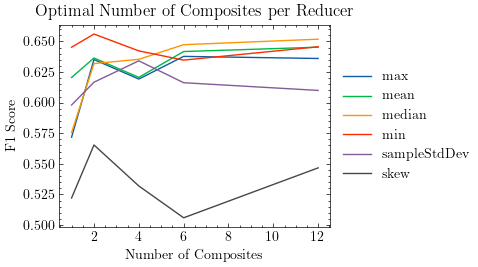

In [5]:
# Draw the RMSEs for each reducer across the number of composites per year
from pathlib import Path

import matplotlib.pyplot as plt
import scienceplots  # noqa: F401
from matplotlib import ticker

plt.style.use("science")

history = pd.read_csv("../reports/compositing.csv")

ax = plt.subplot()
for name, group in history.groupby("Reducer"):
    group.plot(x="Composites", y="F1 Score", ax=ax, label=name)

# Format
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Optimal Number of Composites per Reducer")
ax.set_xlabel("Number of Composites")
ax.set_ylabel("F1 Score")
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

figure_path = f"../reports/figures/compositing/{ax.get_title()}.svg"
Path(figure_path).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(figure_path, dpi=300, transparent=True)

In [6]:
# Find the best number of composites for each reducer
best_combinations = history.loc[history.groupby("Reducer")["F1 Score"].idxmax()]

best_composites = pd.DataFrame(
    data=best_combinations["Composites"].values,
    index=list(best_combinations["Reducer"]),
    columns=["Best Number of Composites"],
)

best_composites

,Best Number of Composites
max,6
mean,12
median,12
min,2
sampleStdDev,4
skew,2


In [7]:
data_path = Path("../data/processed/compositing/data.csv")
target_path = Path("../data/processed/compositing/target.csv")

if (not data_path.exists()) or (not target_path.exists()):
    total_data = []
    for reducer, row in tqdm(list(best_composites.iterrows())):
        num_composites = row["Best Number of Composites"]
        curr_data, total_target = load_dataset(
            f"../data/processed/compositing/data_{reducer}_{num_composites}/",
            target_folder,
        )
        total_data.append(interpolate_data(curr_data))

    total_data = pd.concat(total_data, axis=1)

    total_data.to_csv(data_path, index=False)
    total_target.to_csv(target_path, index=False)
else:
    total_data = pd.read_csv(data_path)
    total_target = pd.read_csv(target_path)["0"]

In [8]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score

model = RandomForestClassifier(n_jobs=-1, random_state=42)
scoring = {
    "F1 Score": make_scorer(f1_score),
    "Accuracy": make_scorer(accuracy_score),
    "Cohen Kappa": make_scorer(cohen_kappa_score),
}
cv_results = cross_validate(
    model, total_data, total_target, cv=StratifiedKFold(n_splits=5), scoring=scoring
)

metrics = {
    key[5:]: val.mean() for key, val in cv_results.items() if key.startswith("test_")
}
metrics

{'F1 Score': np.float64(0.10119791548930931),
 'Accuracy': np.float64(0.8006002551532353),
 'Cohen Kappa': np.float64(0.03150782084615551)}